In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import glob
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from asreview import open_state
from asreviewcontrib.insights.plot import plot_recall
from asreviewcontrib.insights.plot import _recall_values
from asreviewcontrib.insights.utils import pad_simulation_labels
from langdetect import detect
import pylab

# Dataset descriptives

In [2]:
data_descriptives = pd.read_csv("./output/tables/data_descriptives.csv")
data_descriptives.head()

,Unnamed: 0,n_records,n_relevant,n_irrelevant,n_unlabeled,n_missing_title,n_missing_abstract,n_duplicates
0,data_stats_Hamilton_English.json,1859,87,1772,0,5,305,9
1,data_stats_Hamilton_Multi_1.json,1859,87,1772,0,5,305,9
2,data_stats_Hamilton_Multi_2.json,1859,87,1772,0,5,305,9
3,data_stats_Hamilton_Original.json,1859,87,1772,0,5,305,9


## Dataset performance

In [3]:
data_metrics = pd.read_csv("./output/tables/data_metrics.csv")
data_metrics.head()

,Unnamed: 0,file_name,recall_0.1,recall_0.25,recall_0.5,recall_0.75,recall_0.9,wss_0.95,erf_0.1,atd
0,0,metrics_sim_Hamilton_English_logistic_distilus...,0.674419,0.941860,1.000000,1.0,1.0,0.691438,0.569767,163.720930
1,1,metrics_sim_Hamilton_English_logistic_mpnet_0....,0.593023,0.941860,1.000000,1.0,1.0,0.689284,0.488372,190.348837
2,2,metrics_sim_Hamilton_English_logistic_sbert_0....,0.883721,0.976744,0.988372,1.0,1.0,0.815832,0.779070,108.104651
3,3,metrics_sim_Hamilton_English_logistic_tfidf_0....,0.779070,0.941860,1.000000,1.0,1.0,0.692515,0.674419,131.430233
4,4,metrics_sim_Hamilton_Multi_1_logistic_distilus...,0.697674,0.918605,1.000000,1.0,1.0,0.676898,0.593023,164.872093


## Retrieve all target tds

In [30]:
file = "./output/simulation/Hamilton_{}/metrics/metrics_sim_Hamilton_{}_logistic_{}_0.json"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'sbert', 'distiluse', 'mpnet']

values = []
for dataset in datasets:
    for model in models:
        with open(file.format(dataset, dataset, model)) as f:
            i = next(filter(lambda x: x['id'] == 'td', json.load(f)['data']['items']))['value']
            values.extend([dataset] + [model] + value for value in i)
df = pd.DataFrame(values, columns=['dataset', 'model', 'record_id', 'td'])
targets = df.loc[df.record_id.isin([300, 567, 741, 878, 1112])]
targets

,dataset,model,record_id,td
74,Original,tfidf,741,246
75,Original,tfidf,878,263
81,Original,tfidf,567,581
82,Original,tfidf,300,585
84,Original,tfidf,1112,691
...,...,...,...,...
1303,Multi_2,mpnet,741,38
1366,Multi_2,mpnet,878,443
1368,Multi_2,mpnet,1112,498
1371,Multi_2,mpnet,567,598


## SVM Plots

In [5]:
state_file = "./svm_sims/output/simulation/Hamilton_{}/state_files/sim_Hamilton_{}_svm_{}_0.asreview"
csv_file = "./svm_sims/data/Hamilton_{}.csv"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'sbert', 'mbert', 'muse', 'mlongt5', 'labse', 'laser', 'mpnet', 'minilm', 'stsb']

In [3]:
language_dfs = {}
for dataset in datasets:
    languages = pd.read_csv(csv_file.format(dataset))
    languages['language'] = languages['abstract'].dropna().apply(detect)
    languages.columns.values[0] = 'record_id'
    language_dfs[dataset] = languages

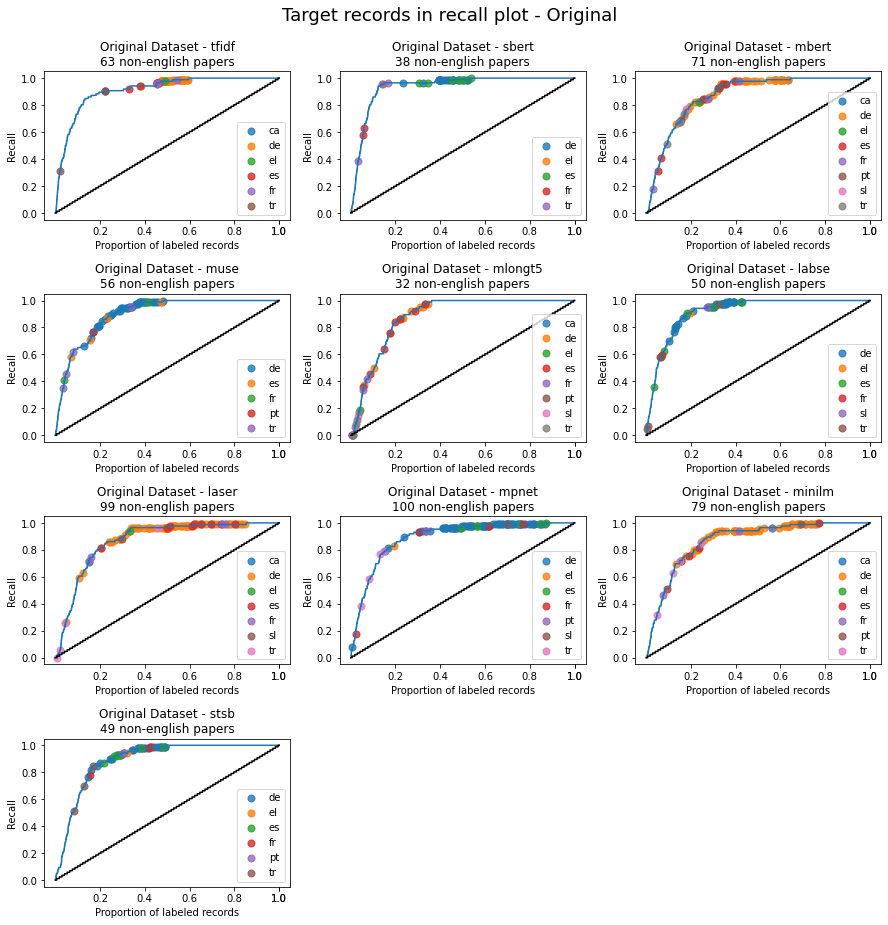

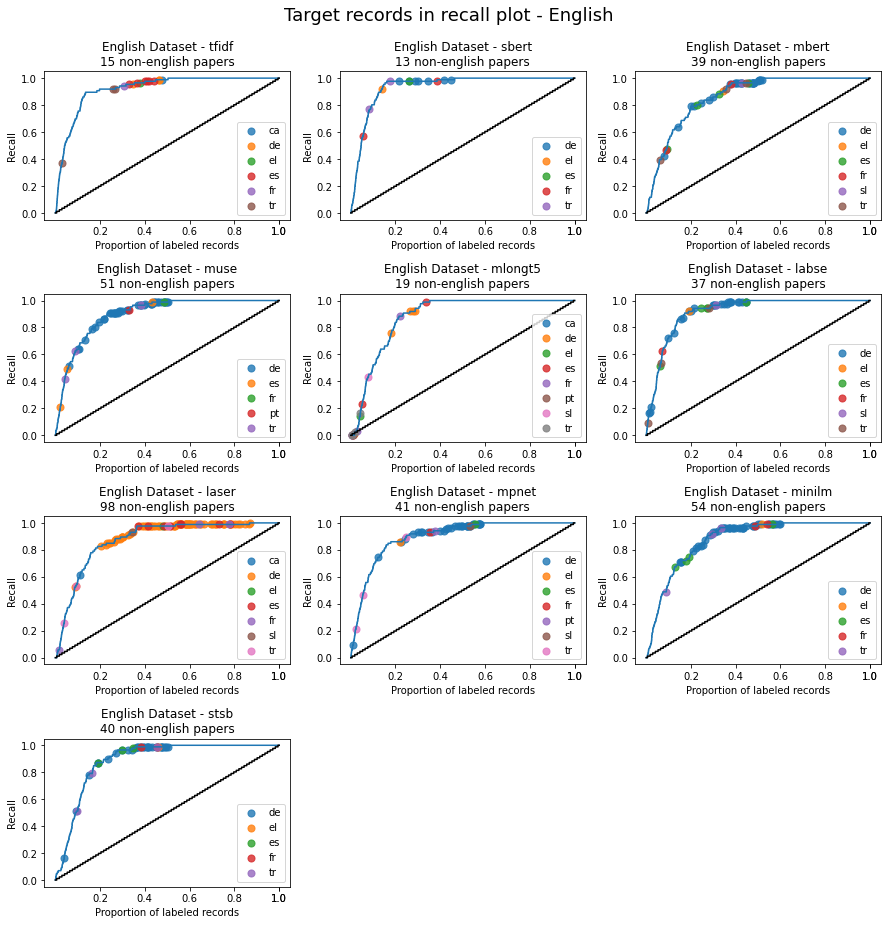

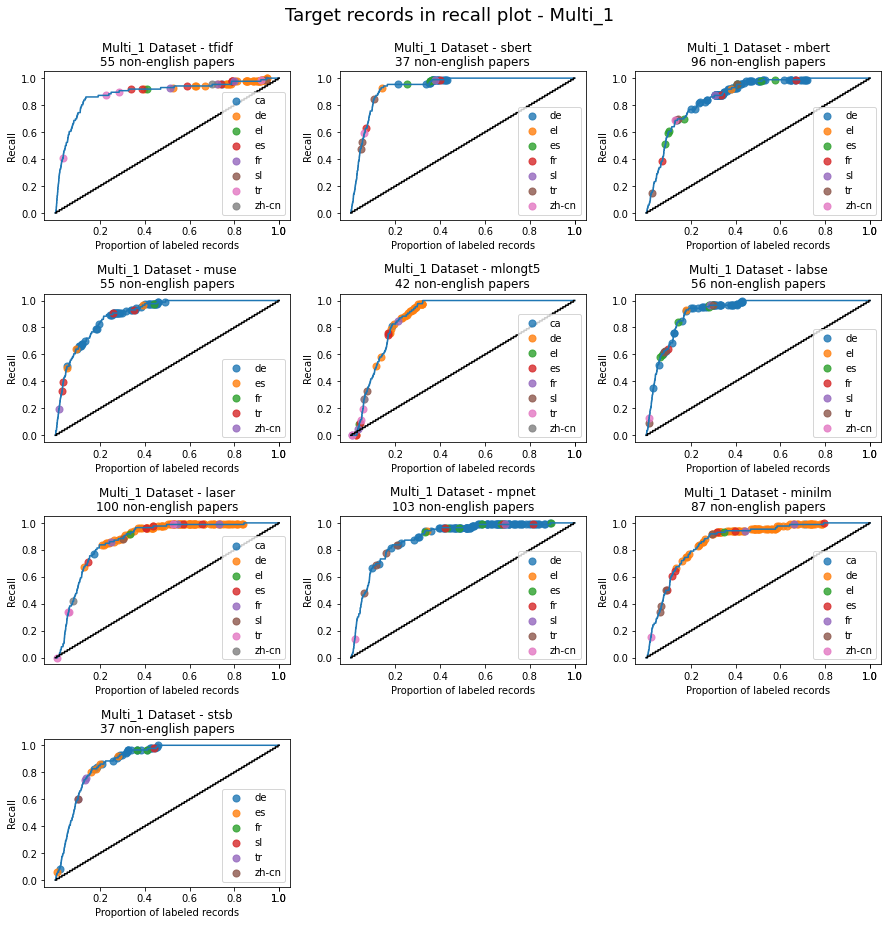

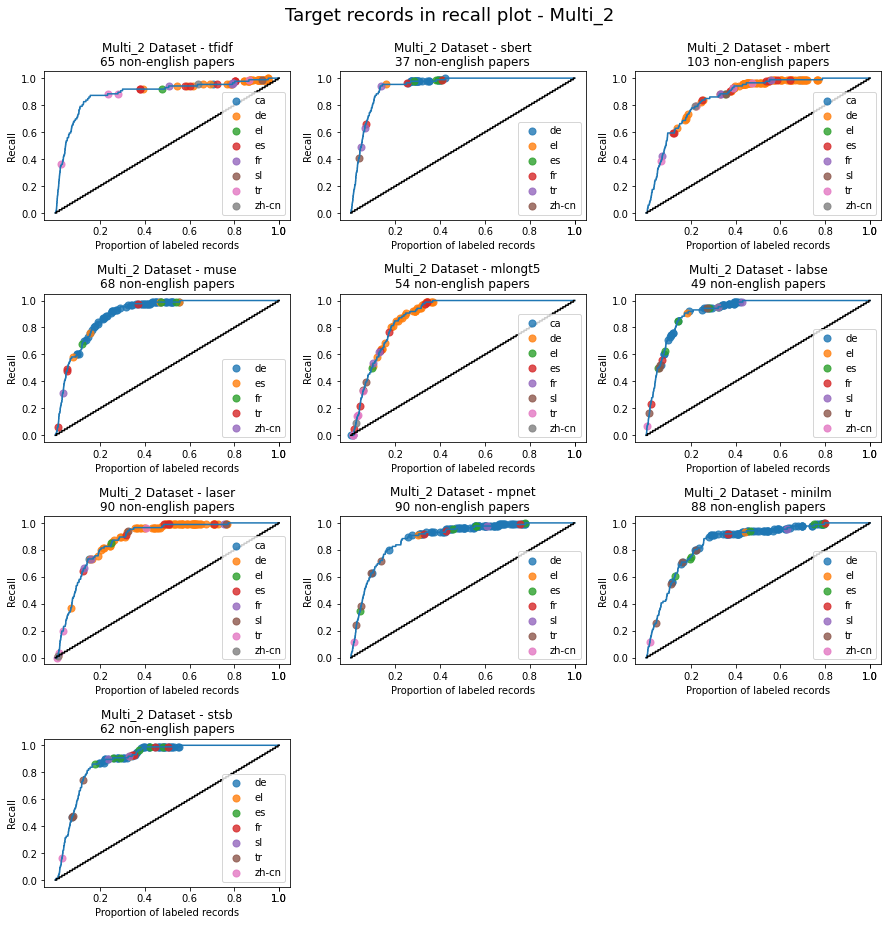

In [6]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.94)
    n=0
    for model in models:
        ax = plt.subplot(4, 3, n + 1)
        with open_state(state_file.format(dataset, dataset, model)) as state:
            states_df = state.get_dataset()
            
            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            
            languages = language_dfs[dataset]
            states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
            non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False))]
            
            #print(non_english.language.head().sort_values().unique())
            
            for language in non_english.language.sort_values().unique():
                temp = non_english.loc[non_english.language==language]
                ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", alpha=0.8, s=50)
            ax.legend(non_english.language.sort_values().unique())
            
            #draw the plot
            plot_recall(ax, state)
   
            ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
            n+=1

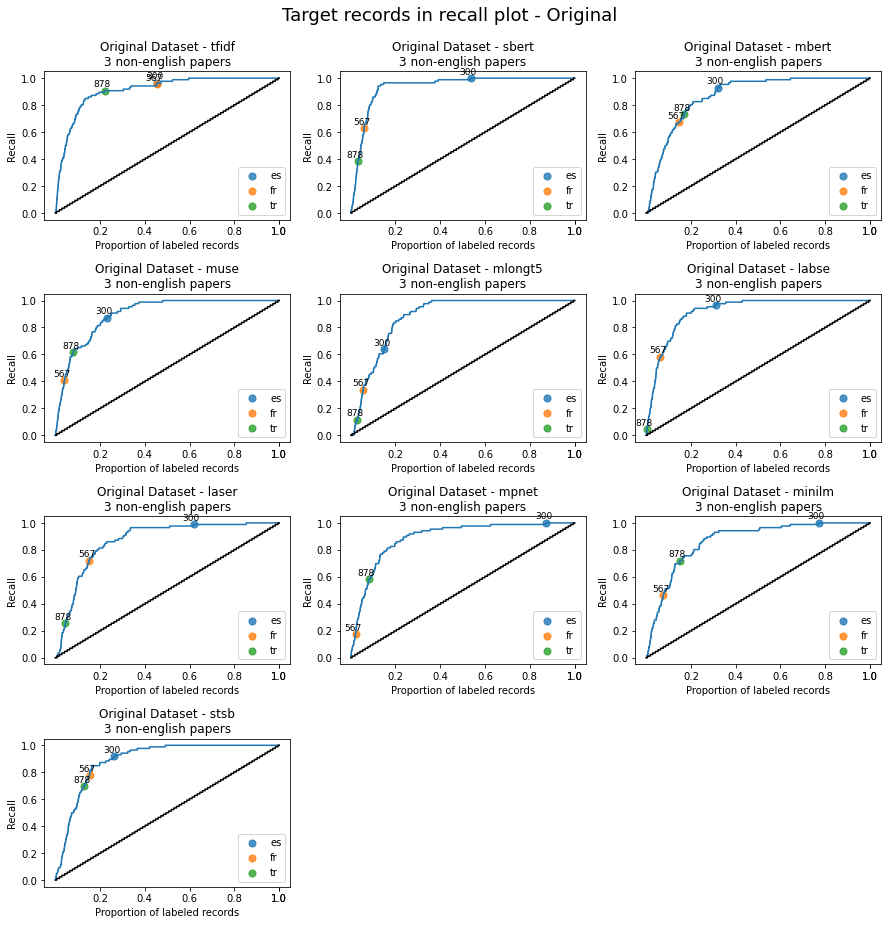

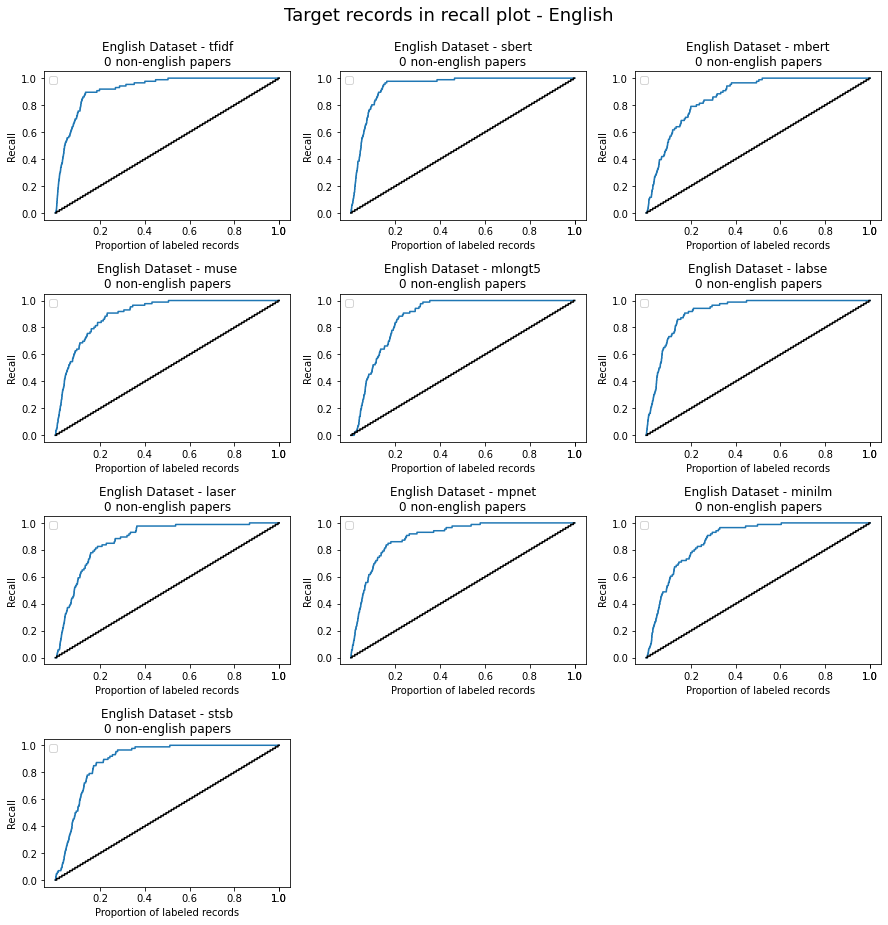

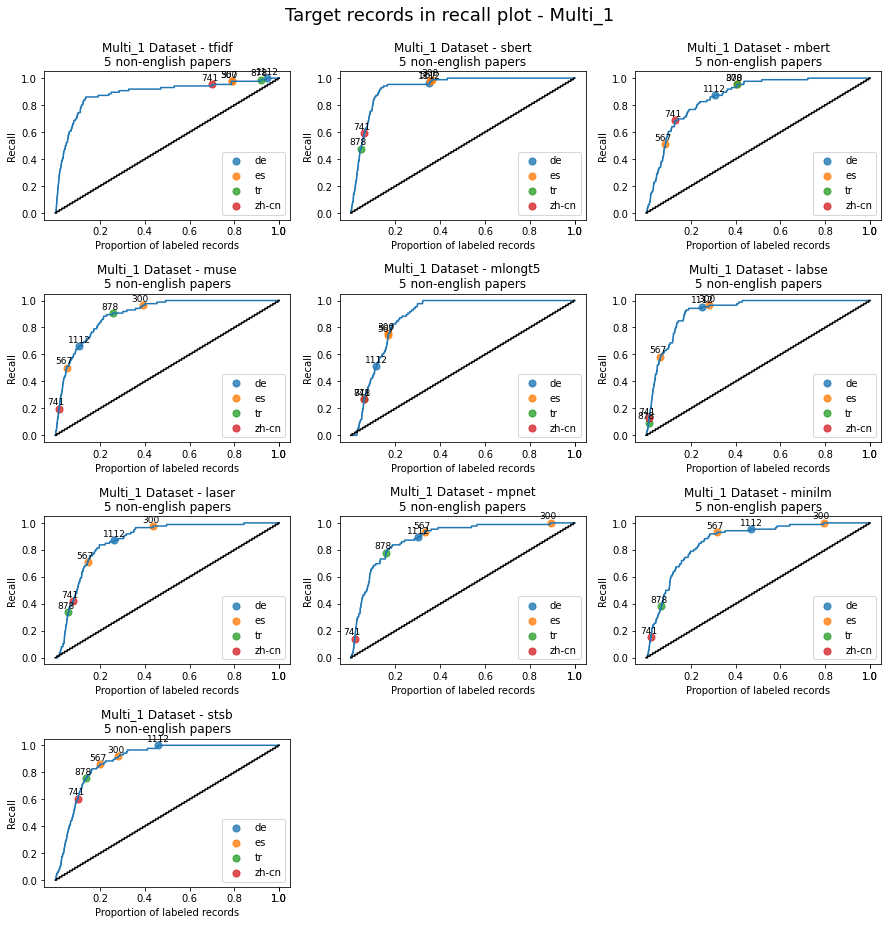

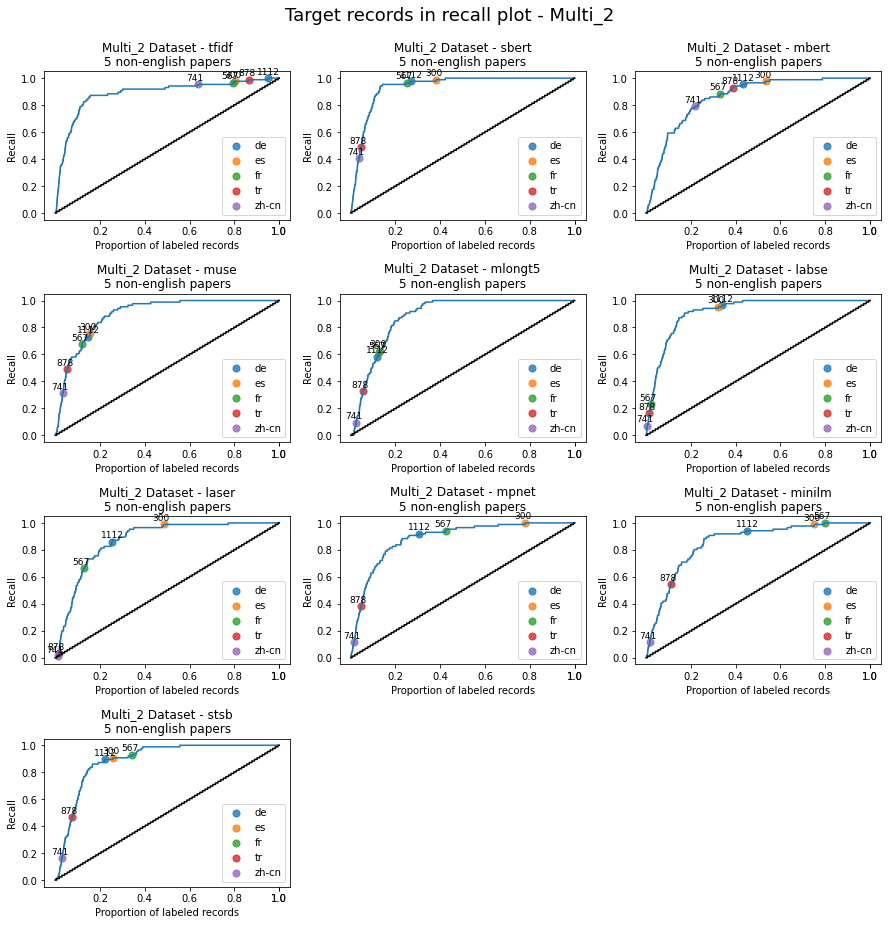

In [7]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.94)
    n=0
    for model in models:
        ax = plt.subplot(4, 3, n + 1)
        with open_state(state_file.format(dataset, dataset, model)) as state:
            states_df = state.get_dataset()
            
            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            
            languages = language_dfs[dataset]
            states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
            non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False)
                                        & (states_df.label == 1))]
            
            for language in non_english.language.sort_values().unique():
                temp = non_english.loc[non_english.language==language]
                ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", s=50, alpha=0.8)
                for index, row in temp.iterrows():
                    ax.text(x[index]-0.05, y[index]+0.03, row.record_id, fontsize=9)
            ax.legend(non_english.language.sort_values().unique())
            
            #draw the plot
            plot_recall(ax, state)
  
            ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
            n+=1

## Logistic Plots

In [10]:
state_file = "./log_sims/output/simulation/Hamilton_{}/state_files/sim_Hamilton_{}_logistic_{}_0.asreview"
csv_file = "./svm_sims/data/Hamilton_{}.csv"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'sbert', 'mbert', 'muse', 'mlongt5', 'labse', 'laser', 'mpnet', 'minilm', 'stsb']

In [17]:
language_dfs = {}
for dataset in datasets:
    languages = pd.read_csv(csv_file.format(dataset))
    languages['language'] = languages['abstract'].dropna().apply(detect)
    languages.columns.values[0] = 'record_id'
    language_dfs[dataset] = languages

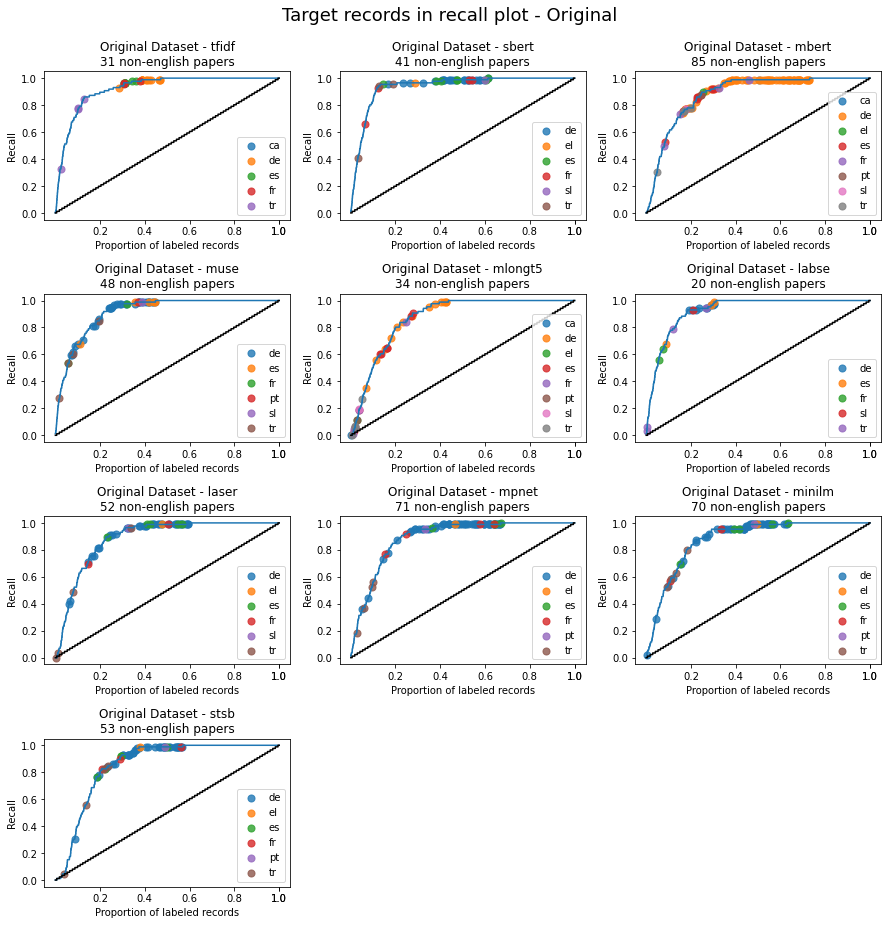

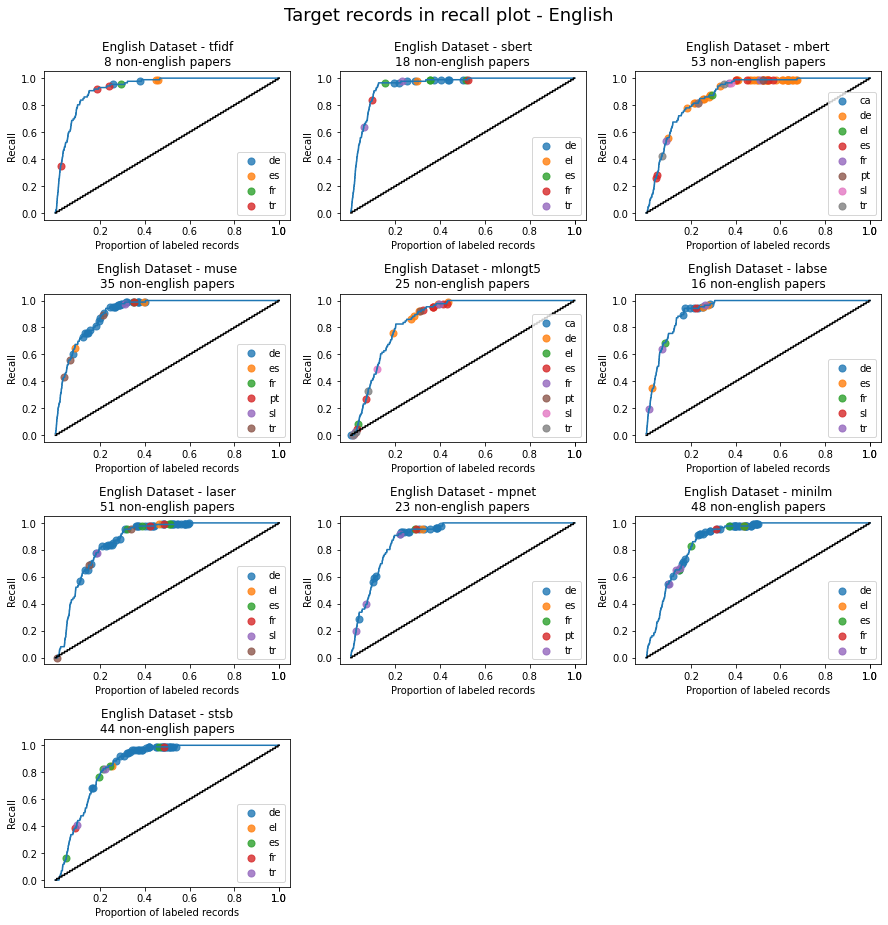

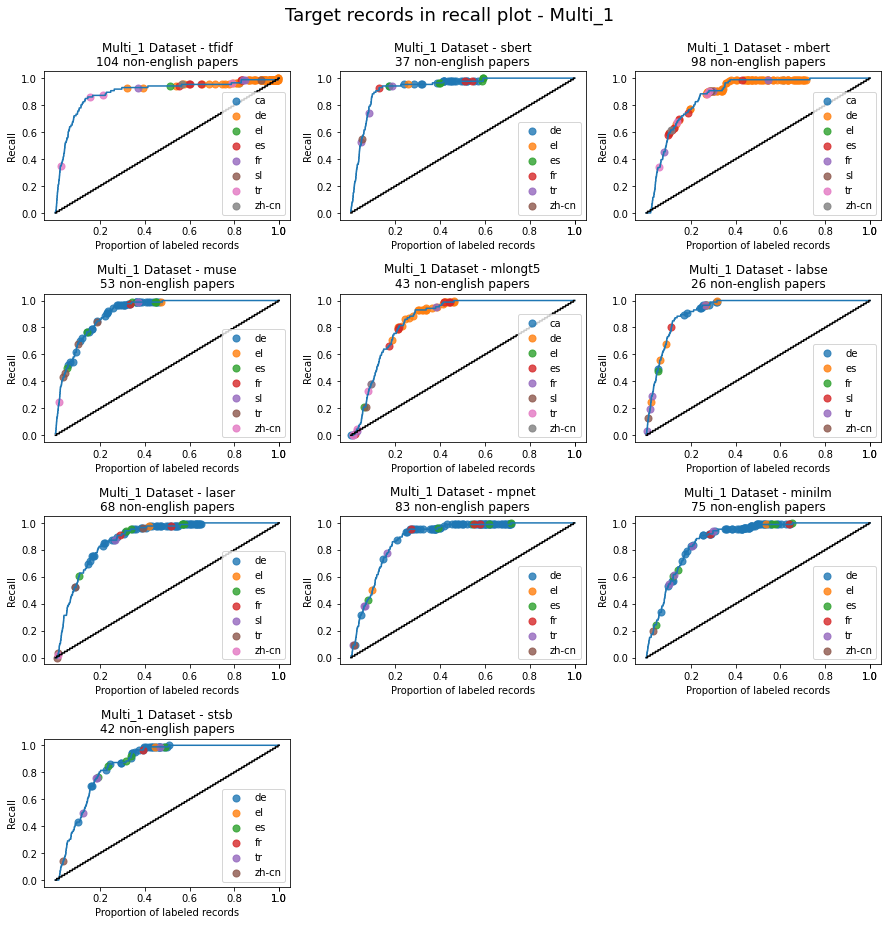

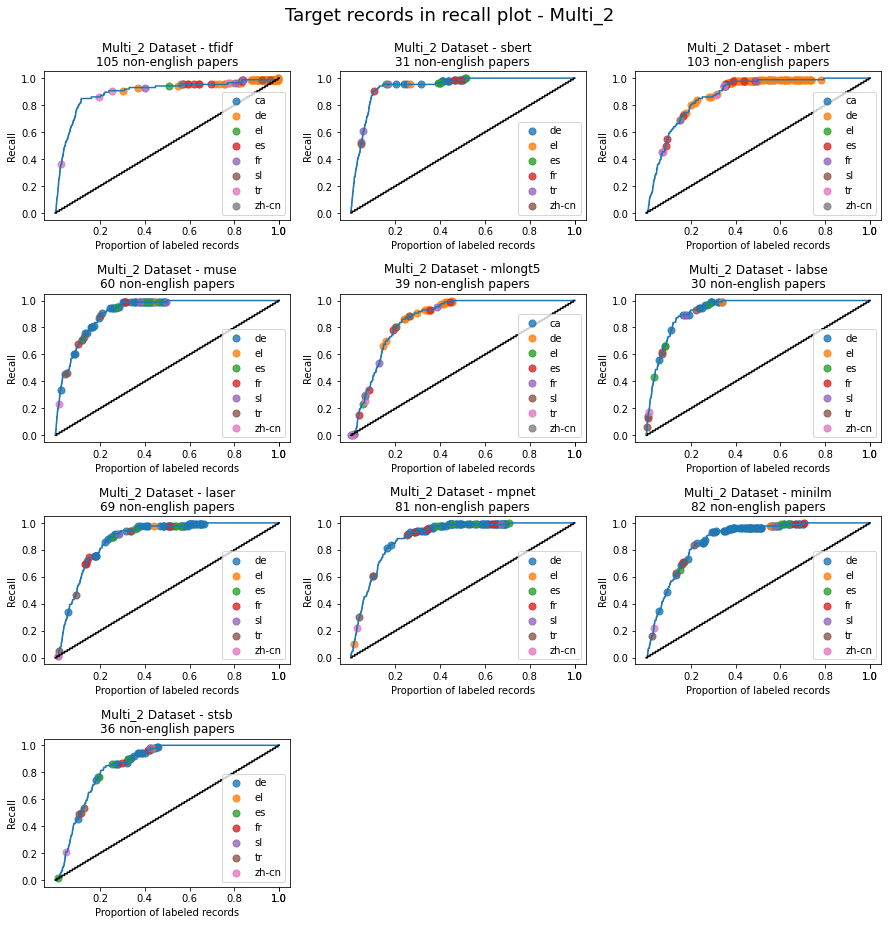

In [11]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.94)
    n=0
    for model in models:
        ax = plt.subplot(4, 3, n + 1)
        with open_state(state_file.format(dataset, dataset, model)) as state:
            states_df = state.get_dataset()
            
            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            
            languages = language_dfs[dataset]
            states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
            non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False))]
            
            #print(non_english.language.head().sort_values().unique())
            
            for language in non_english.language.sort_values().unique():
                temp = non_english.loc[non_english.language==language]
                ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", alpha=0.8, s=50)
            ax.legend(non_english.language.sort_values().unique())
            
            #draw the plot
            plot_recall(ax, state)
   
            ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
            n+=1

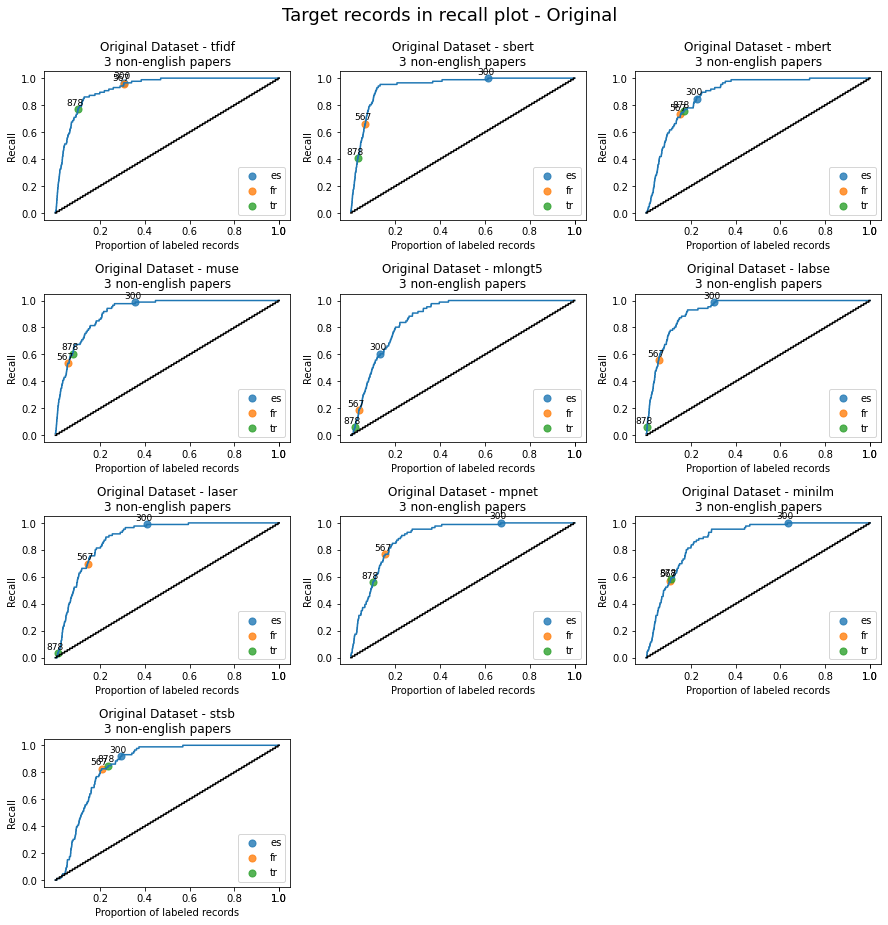

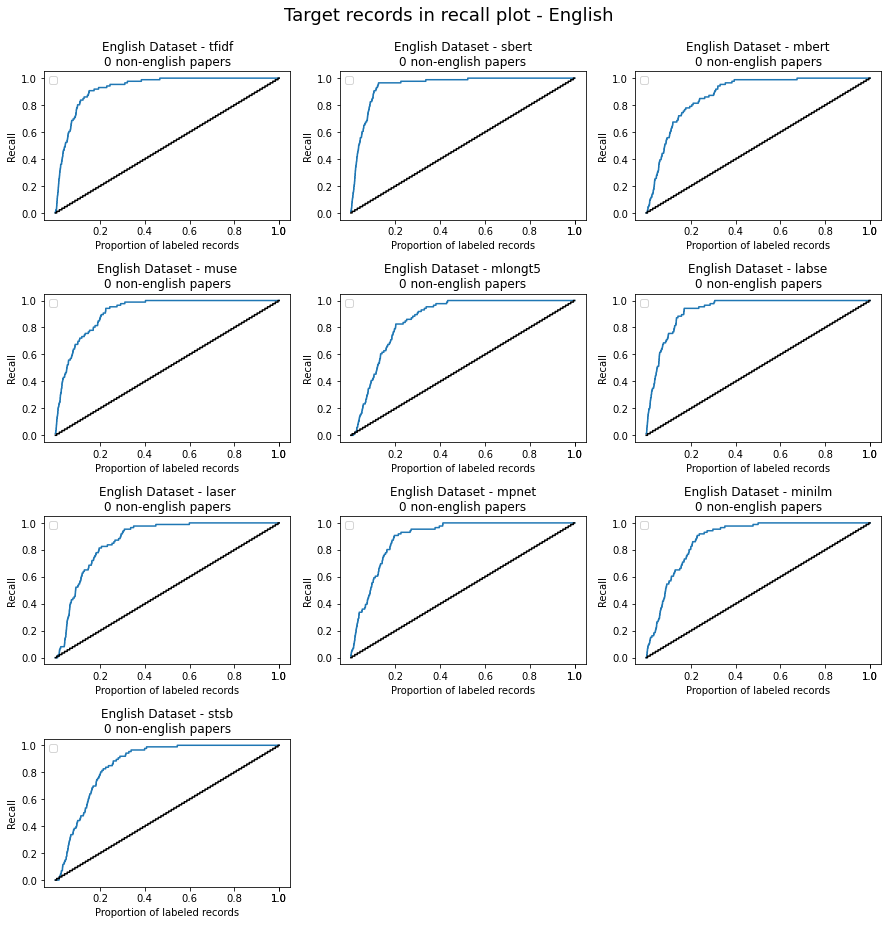

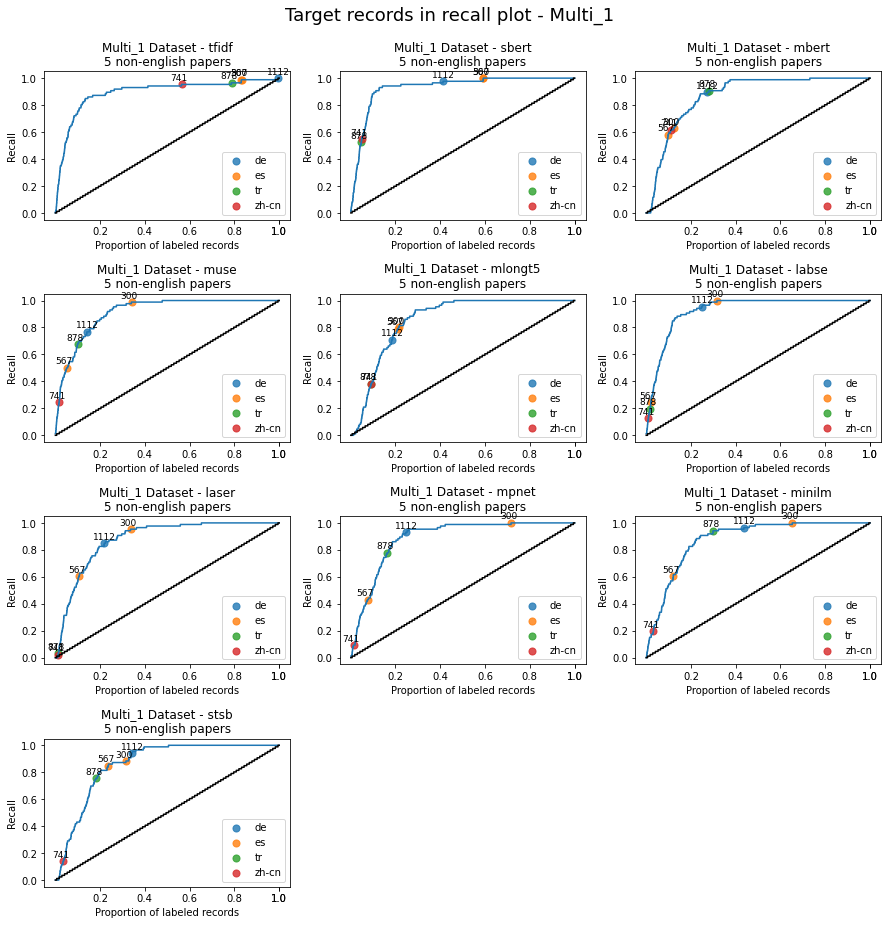

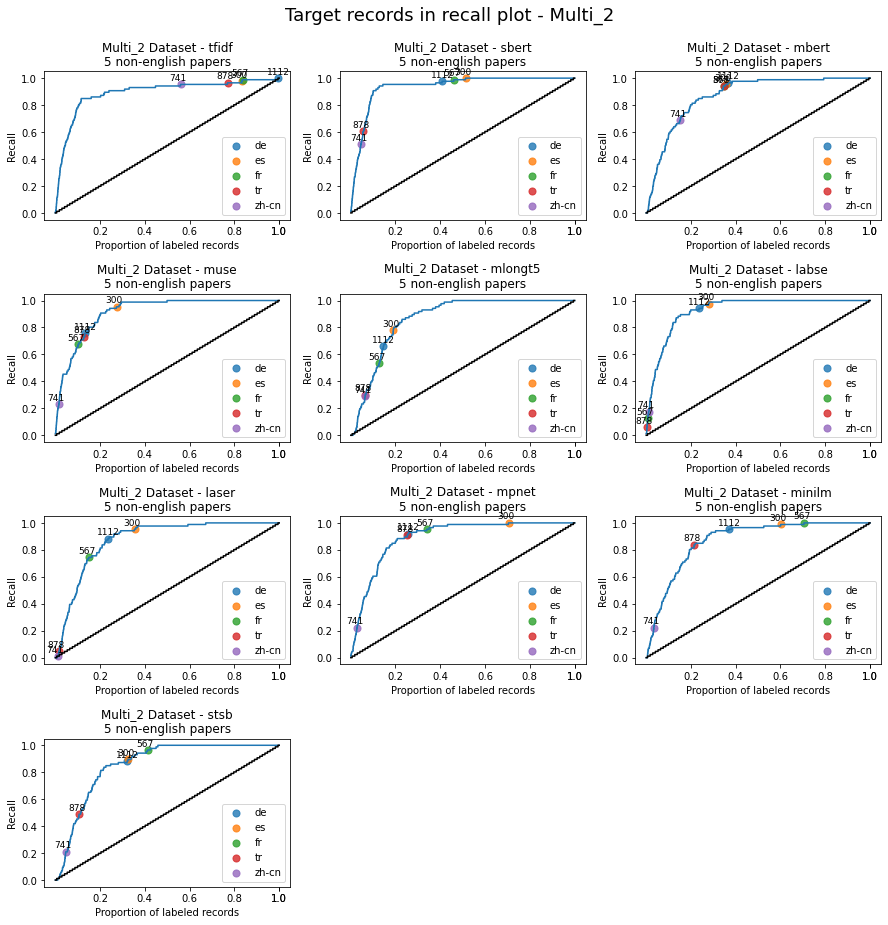

In [12]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.94)
    n=0
    for model in models:
        ax = plt.subplot(4, 3, n + 1)
        with open_state(state_file.format(dataset, dataset, model)) as state:
            states_df = state.get_dataset()
            
            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            
            languages = language_dfs[dataset]
            states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
            non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False)
                                        & (states_df.label == 1))]
            
            for language in non_english.language.sort_values().unique():
                temp = non_english.loc[non_english.language==language]
                ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", s=50, alpha=0.8)
                for index, row in temp.iterrows():
                    ax.text(x[index]-0.05, y[index]+0.03, row.record_id, fontsize=9)
            ax.legend(non_english.language.sort_values().unique())
            
            #draw the plot
            plot_recall(ax, state)
 
            ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
            n+=1